# Parameter Estimation
## Particle Smoother EM (PSEM)
### M-Step: maximize the following Monte Carlo approximation with respect to  $\theta$

$\hat{Q}_r(\theta) = \frac{1}{M_r} \sum_{j=1}^{M_r} \log p(\tilde{x}_{1:T}^j, y_{1:t};\theta)$

where

$M_r$: num. of backward trajectories

$\{ \tilde{x}_{1:T}^j \}_{j=1}^{M_r}$: $p_{\theta[r-1]}(x_{1:T}|y_{1:T})$


### E-step:
\begin{align*}
Q(\theta|\theta^{l}) &= E\left\{\log [p(N_{0,K}, x; \theta)]|| H_K, \theta^{(l)} \right\}\\
&=\int \log p(N_{0,K}, x; \theta) p(x|H_k,\theta^{(l-1)}) dx
\end{align*}

#### use Sequential Monte Carlo to sample backward smoother 

%% $E\{x_k || H_k, \theta^{(l)}\}$, $W_k = E\{x_k^2 || H_k, \theta^{(l)}\}$ and $W_{k,k+1}=E\{x_k x_{k-1} || H_k, \theta^{(l)}\}$

### M-step:

$\sigma_{\epsilon K}^{2(l+1)} = K^{-1} [\sum_{k=1}^K W_k +\sum_{k=1}^K W_{k-1} -2\sum_{k=1}^K W_{k,k-1}]$

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
sys.path.insert(1,'./code')
from visualize import plot_raw_data, get_population_data, plot_results
from EM import TransformToProb, RunEM
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [ ]:
# Get a set of whisker data and plot the raster plot
path = 'put in path to the Data folder'
resp_values_1711 = get_population_data(17,1,1, path = path)
plot_raw_data(17,1,1,0,figsize=[15,9])

resp_values_1711 is the loaded whisker data and it's of shape (50,3000), you need to sum it up across axis 0 and then use the data.

In [ ]:
print resp_values_1711.shape
Y = np.sum(resp_values_1711, axis = 0)
print Y.shape

In [ ]:
# Run EM on the data set and show results
pmode_1711, p_1711, pll_1711, pul_1711, sigma2e_1711 = RunEM(resp_values_1711)
plot_results(resp_values_1711, pmode_1711, p_1711, pll_1711, pul_1711, ylim=[0,0.75])

In [ ]:
print sigma2e_1711

Create a list of sigmas around `sigma2e_1711`.

In [ ]:
sigma_ls = np.arange(sigma2e_1711-0.2, sigma2e_1711+0.2,0.01)
print len(sigma_ls)

Now evaluate likelikehood using the list of sigmas. Feel free to play around with the list of sigmas and the step sizes.

In [4]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Binom(50,\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
         return np.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)

        yrep = np.repeat(np.asarray(y), N, 0)
    
        lpy = scipy.stats.binom.logpmf(yrep,50,np.exp(particles[:,0])/(1.0 + np.exp(particles[:,0])),loc=0)
    
        return lpy

In [5]:
#df = pd.read_csv('thaldata.csv',header=None)
#Y = df.values.reshape(3000)
mat = np.loadtxt('train_data.txt')
Y = mat[0,1:]
T = len(Y)

In [6]:
# Forward particles
N = 100
# Backward trajectories
M = 30
#iterations
iteration=40
#initial_sigma
sigma_ls = np.empty(iteration+1)
sigma_ls[0]=0.01

In [7]:
%%time
for i in range(iteration):
    P0 = sigma_ls[i] * np.eye(1)    
    Q = sigma_ls[i] * np.eye(1)
    model = StdNonLin(P0, Q)
    sim = simulator.Simulator(model,u=None,y=Y)
    sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
    est_smooth = sim.get_smoothed_estimates()
    posteriorcovariance=np.array(np.diff(est_smooth[:,:,0],axis=0))**2
    sigma_ls[i+1] = np.sum(posteriorcovariance/(M*T)) * np.eye(1)

CPU times: user 1min 1s, sys: 817 ms, total: 1min 2s
Wall time: 1min 4s


15min: 3000timesteps, 500 forward, 100 backward, 500 iterations

In [26]:
sigma_ls

array([ 0.01      ,  0.06644789,  0.19164428,  0.33102916,  0.44098081,
        0.5090751 ,  0.55189566,  0.57269644,  0.57918624,  0.58720913,
        0.59473333,  0.60086198,  0.59780295,  0.60239949,  0.60046486,
        0.60115298,  0.59878344,  0.60099771,  0.59625898,  0.60542182,
        0.60160598,  0.59834438,  0.59940613,  0.60263305,  0.59711959,
        0.59374953,  0.59512675,  0.5926694 ,  0.59208151,  0.5987576 ,
        0.59843511,  0.59944764,  0.59665294,  0.59801472,  0.59588461,
        0.5932053 ,  0.59257518,  0.6021329 ,  0.59933655,  0.59449423,
        0.59379095,  0.59357462,  0.59753038,  0.59900322,  0.59953467,
        0.60269856,  0.59971152,  0.60104714,  0.59530626,  0.59438229,
        0.591382  ,  0.59434506,  0.59261686,  0.59417665,  0.60093936,
        0.60211062,  0.59270737,  0.58948169,  0.59553038,  0.59844842,
        0.59810908,  0.59826929,  0.60218439,  0.60098624,  0.5997131 ,
        0.60077135,  0.60098285,  0.59491154,  0.59366969,  0.59

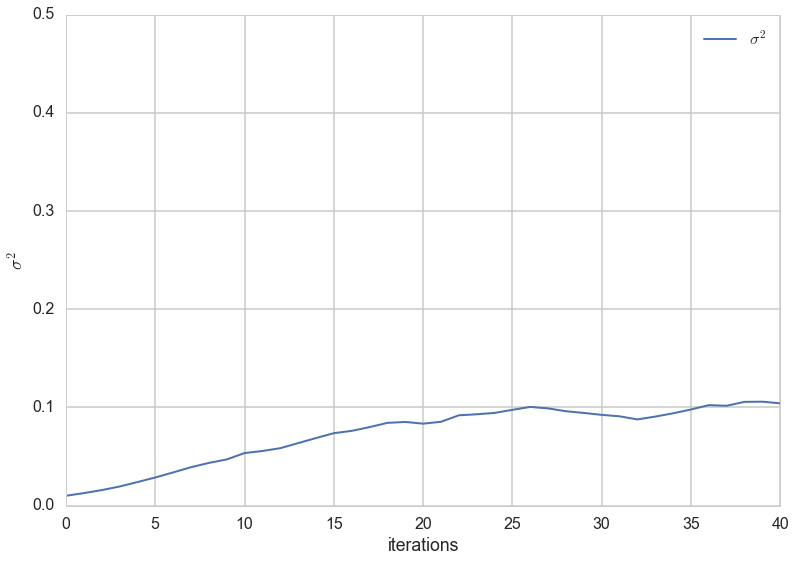

In [8]:
plt.plot(sigma_ls, '-',linewidth=2.0, label=r'$\sigma^2$')
plt.ylim([0,0.5])
plt.ylabel('$\sigma^2$')
plt.xlabel('iterations')
plt.legend(loc='best')

In [109]:
sigma_ls

array([ 0.01      ,  0.01250788,  0.01466892, ...,  0.10658171,
        0.10625818,  0.10945746])

In [94]:
print b.shape

(501,)


In [95]:
sigma_ls.shape

(501,)

In [100]:
e=np.reshape([b,sigma_ls],1002)

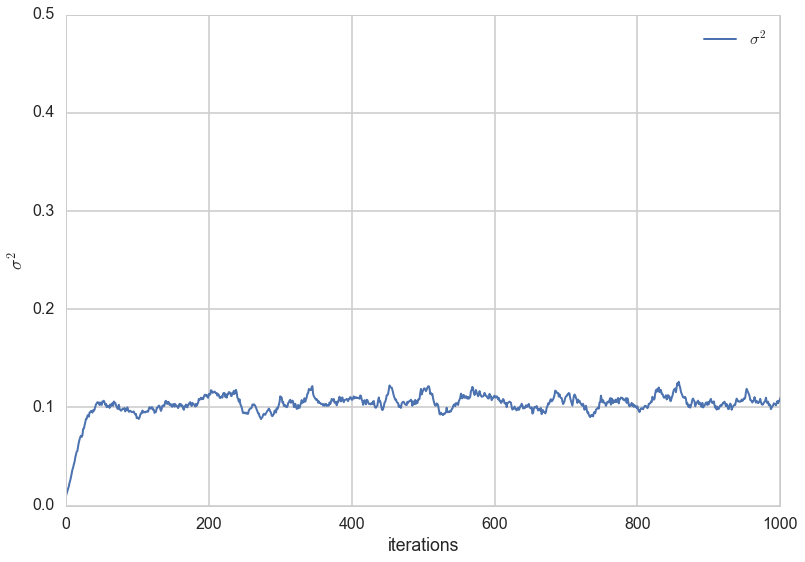

In [110]:
plt.plot(sigma_ls, '-',linewidth=2.0, label=r'$\sigma^2$')
plt.ylim([0,0.5])
plt.ylabel('$\sigma^2$')
plt.xlabel('iterations')
plt.legend(loc='best')

0